In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.tabular.all import *
from wwf.tab.export import *

In [3]:
from bnbsl import *

In [4]:
SEASON = '23'
set_seed(int(SEASON))

## Data preparation

In [5]:
path = Path()
path_data = Path('data')

In [6]:
df = pd.read_csv(path_data/'data.csv', dtype={'HC':'float', 'AC':'float'}, parse_dates=['Date'])

In [7]:
div = ['E0', 'E1', 'E2', 'D1', 'D2', 'SP1', 'SP2', 'I1', 'I2', 'F1', 'F2']
df = df[(df.Div.isin(div)) & (df.Season >= int(SEASON)-4) & (df.Season <= int(SEASON))]

# Drop NA corner
df = df.dropna().reset_index(drop=True)

In [8]:
add_datepart(df, 'Date');

In [9]:
# Time-weighted
df['weight'] = np.exp(-(df.Elapsed.max() - df.Elapsed) / (3600*24*365) / df.Year.nunique())
df['weight'] = df['weight'] / df['weight'].mean()

In [10]:
procs = [Categorify, FillMissing, Normalize]

In [11]:
valid_idx = list(df.query(f'Season == {SEASON}').index)

In [13]:
splitter = IndexSplitter(valid_idx)
splits = splitter(range_of(df))

In [14]:
splits

((#17401) [0,1,2,3,4,5,6,7,8,9...],
 (#132) [2439,2440,2441,2442,2443,2444,2445,2446,2447,2448...])

In [15]:
y_names = ['HC', 'AC']
cat_names = ['Div', 'HomeTeam', 'AwayTeam']
# cont_names = list(df.columns[df.columns.str.contains('Avg')])

In [16]:
cont_names = [
    'HSLast5Avg', 
    'HCLast5Avg', 
    'ASLast5Avg', 
    'ACLast5Avg', 
    'HomeSForLast5Avg', 
    # 'HomeCForLast5Avg', 
    'AwaySForLast5Avg', 
    # 'AwayCForLast5Avg',
    'HomeSAgainstLast5Avg', 
    # 'HomeCAgainstLast5Avg', 
    'AwaySAgainstLast5Avg', 
    # 'AwayCAgainstLast5Avg',
]

In [17]:
y_block = RegressionBlock(n_out=2)

In [18]:
df.sample(10)

,Div,HomeTeam,AwayTeam,FTHG,FTAG,HS,AS,HST,AST,HC,...,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,weight
14958,SP1,Ath Madrid,Villarreal,2.0,2.0,24.0,2.0,5.0,2.0,16.0,...,6,241,False,False,False,False,False,False,1.630195e+09,0.993161
2790,E0,Sheffield United,Wolves,1.0,0.0,7.0,6.0,3.0,1.0,6.0,...,2,190,False,False,False,False,False,False,1.594166e+09,0.790290
4007,E1,Sheffield Weds,Barnsley,2.0,0.0,16.0,11.0,7.0,3.0,6.0,...,5,222,False,False,False,False,False,False,1.565395e+09,0.658480
12047,I1,Verona,Empoli,2.0,1.0,22.0,9.0,5.0,4.0,1.0,...,0,326,False,False,False,False,False,False,1.637539e+09,1.040512
9189,F1,Monaco,Lyon,2.0,0.0,10.0,19.0,6.0,5.0,3.0,...,5,36,False,False,False,False,False,False,1.644019e+09,1.084163
7308,E2,Gillingham,Sunderland,1.0,2.0,25.0,14.0,8.0,5.0,6.0,...,5,289,False,False,False,False,False,False,1.634342e+09,1.019629
7228,E2,Wigan,Portsmouth,1.0,0.0,4.0,10.0,2.0,2.0,2.0,...,5,240,False,False,False,False,False,False,1.630109e+09,0.992617
16772,SP2,Mirandes,Huesca,0.0,1.0,15.0,13.0,4.0,4.0,5.0,...,5,317,False,False,False,False,False,False,1.636762e+09,1.035393
11727,I1,Torino,Fiorentina,1.0,1.0,15.0,9.0,6.0,3.0,7.0,...,4,29,False,False,False,False,False,False,1.611878e+09,0.884240
2986,E0,Man United,Wolves,1.0,0.0,11.0,9.0,3.0,5.0,2.0,...,1,364,False,False,False,False,False,False,1.609200e+09,0.869347


In [19]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [20]:
to.cat_names, to.cont_names

((#3) ['Div','HomeTeam','AwayTeam'],
 (#8) ['HSLast5Avg','HCLast5Avg','ASLast5Avg','ACLast5Avg','HomeSForLast5Avg','AwaySForLast5Avg','HomeSAgainstLast5Avg','AwaySAgainstLast5Avg'])

In [21]:
display_df(to.xs.iloc[-2:])

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg
17531,11,159,6,-0.118759,0.105425,1.027998,-0.513214,-0.324947,-1.209205,-0.165776,1.157812
17532,11,241,180,1.593700,0.937124,-1.961293,-1.595937,0.576537,-0.911876,-0.385339,0.863726


### To other packages (e.g. Scikit-learn, LightGBM, XGBoost)

In [22]:
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor

In [23]:
X_train, y_train = to.train.xs, to.train.ys.values
X_test, y_test = to.valid.xs, to.valid.ys.values

In [24]:
X_train.shape, y_train.shape

((17401, 11), (17401, 2))

In [25]:
X_test.shape, y_test.shape

((132, 11), (132, 2))

## LightGBM

In [26]:
fit_params = {'feature_name':list(X_test.columns), 'categorical_feature':cat_names}

In [27]:
m_lgbm = MultiOutputRegressor(LGBMRegressor(objective='poisson', n_estimators=100, n_jobs=-1, reg_lambda=1.0))
m_lgbm.fit(X_train, y_train, **fit_params)

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/lightgbm/basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


MultiOutputRegressor(estimator=LGBMRegressor(objective='poisson',
                                             reg_lambda=1.0))

In [28]:
import lightgbm as lgbm

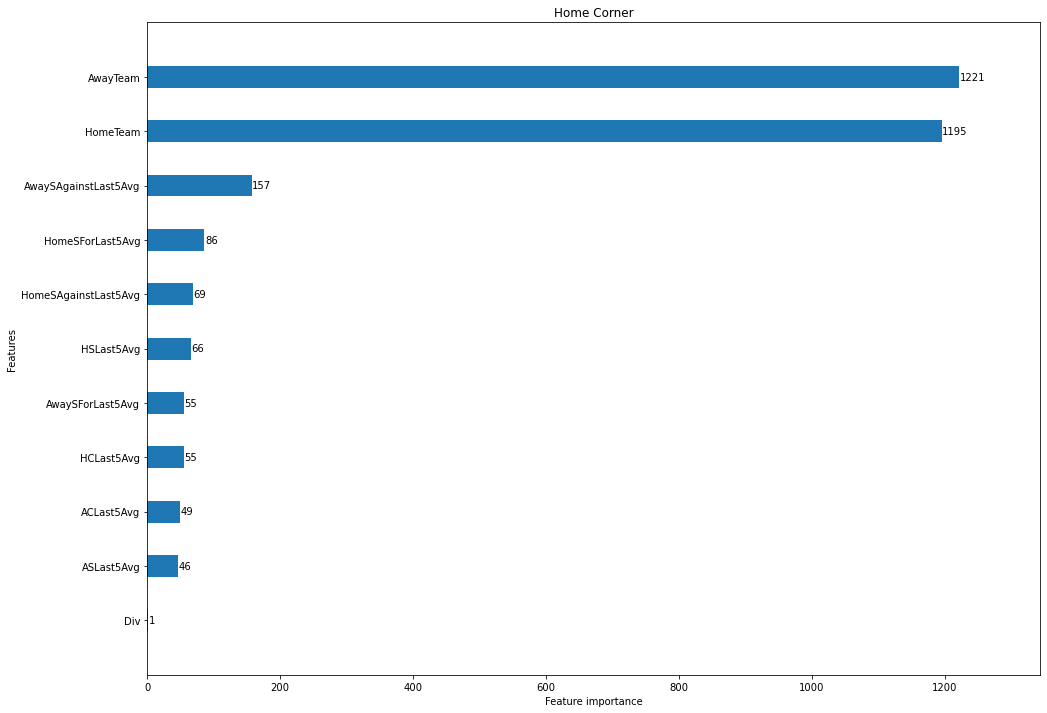

In [29]:
lgbm.plot_importance(m_lgbm.estimators_[0], figsize=(16, 12), title='Home Corner', max_num_features=40, height=0.4, grid=False);

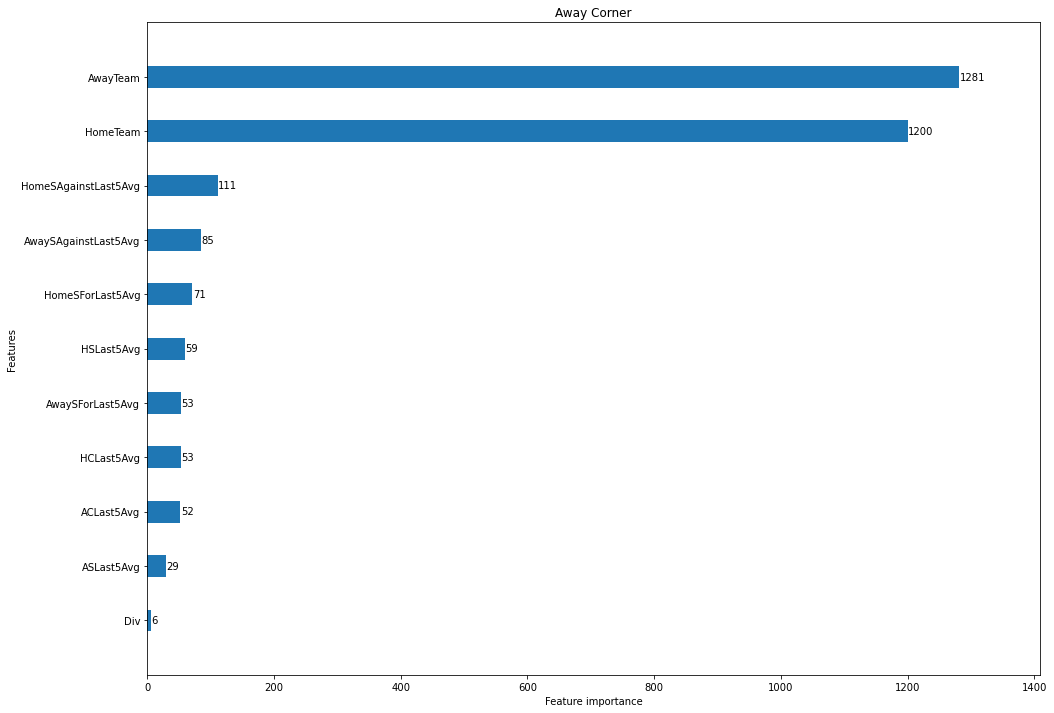

In [30]:
lgbm.plot_importance(m_lgbm.estimators_[1], figsize=(16, 12), title='Away Corner', max_num_features=40, height=0.4, grid=False);

## XGBoost

In [31]:
m_xgb = MultiOutputRegressor(XGBRegressor(objective='count:poisson', n_estimators=100, n_jobs=-1, tree_method='exact'))
m_xgb.fit(X_train, y_train)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, gamma=None,
                                            gpu_id=None, importance_type='gain',
                                            interaction_constraints=None,
                                            learning_rate=None,
                                            max_delta_step=None, max_depth=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            objective='count:poisson',
                                            rand

In [32]:
import xgboost as xgb

In [33]:
for i in range(0, 2):
    m_xgb.estimators_[i].get_booster().feature_names = list(X_test.columns)

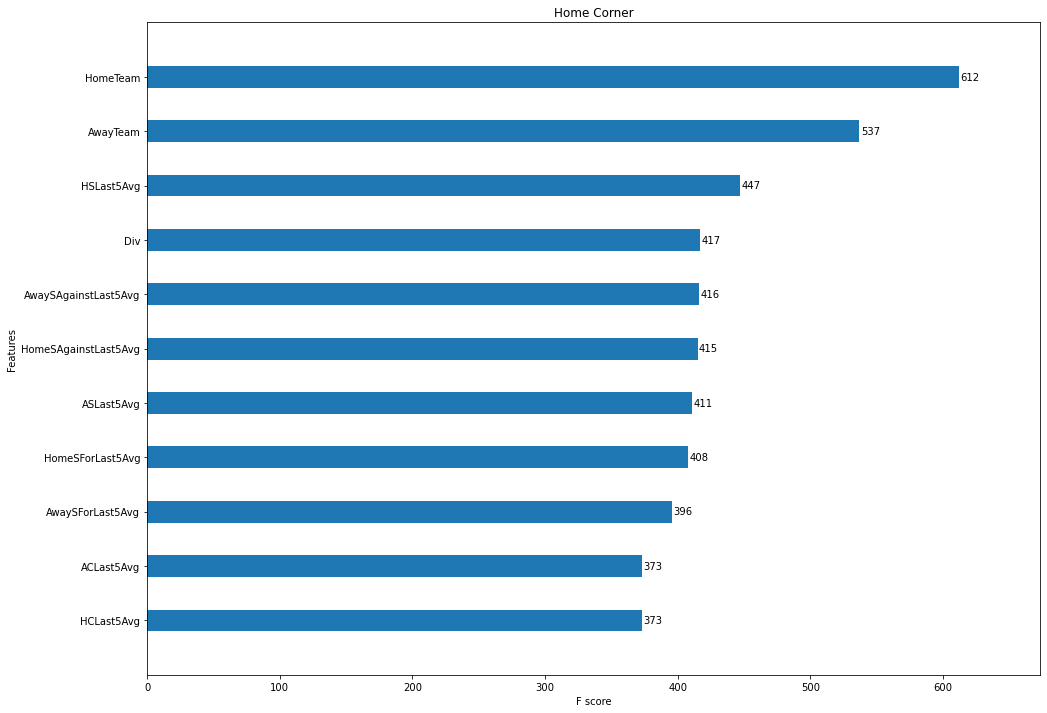

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[0], title='Home Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

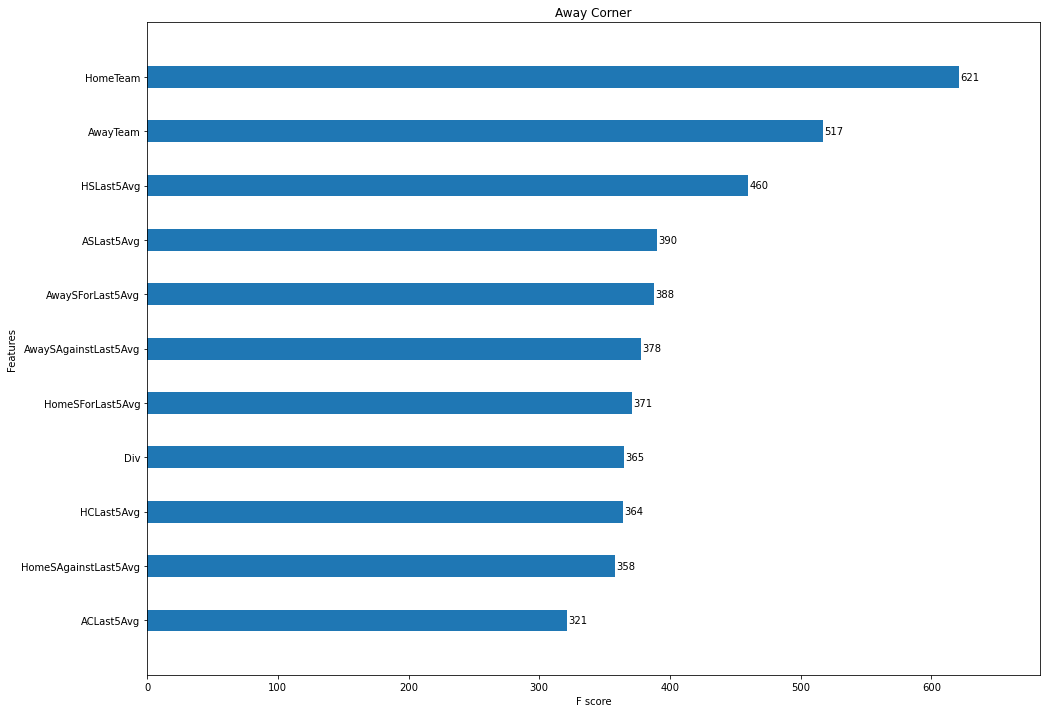

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(16, 12))
xgb.plot_importance(m_xgb.estimators_[1], title='Away Corner', max_num_features=40, height=0.4, grid=False, ax=ax);

## Poisson

In [36]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC
0,I1,Benevento,Milan,7.0,4.0,9.400000,5.8,8.600000,10.6,6.2,9.2,12.0,4.0
1,SP1,Betis,Villarreal,14.2,6.0,9.600000,3.8,13.800000,10.8,10.2,10.2,1.0,5.0
2,SP1,Alaves,Granada,12.0,5.2,9.600000,3.2,9.000000,8.0,10.2,12.8,6.0,1.0
3,E1,Huddersfield,Burnley,9.4,4.8,12.400000,5.0,9.200000,12.2,13.6,15.2,1.0,5.0
4,F1,Strasbourg,Nice,14.2,5.6,16.200001,6.8,10.600000,17.6,11.2,11.8,2.0,3.0
5,SP2,Numancia,La Coruna,14.8,5.2,9.400000,3.2,13.200000,10.4,12.4,12.8,4.0,7.0
6,F1,Lyon,Strasbourg,10.6,6.0,11.200000,5.4,13.200000,13.0,10.0,9.4,3.0,2.0
7,I2,Venezia,Ascoli,14.6,6.0,12.600000,5.2,16.200001,13.8,9.4,17.0,4.0,3.0
8,SP2,Mirandes,Albacete,13.4,4.6,7.800000,2.0,8.400000,8.8,10.2,15.2,7.0,5.0
9,I2,Ascoli,Spal,13.4,3.2,12.000000,4.2,13.400000,21.0,14.8,10.8,4.0,3.0


In [37]:
learn = tabular_learner(dls, layers=[240, 120])

In [38]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(272, 37)
    (2): Embedding(272, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=2, bias=True)
    )
  )
)

In [39]:
learn.loss_func = BaseLoss(partial(nn.PoissonNLLLoss, log_input=True, full=True), floatify=True)

SuggestedLRs(valley=0.0030199517495930195)

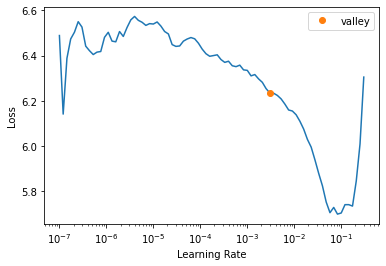

In [40]:
learn.lr_find()

In [41]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time


In [42]:
df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
3224,3.0,11.0


In [43]:
_, _, params = learn.predict(df.query('Season==21 and HomeTeam=="Tottenham" and AwayTeam=="Man City"')
                               .drop(columns=y_names).iloc[0])

In [44]:
pois_corner_home = torch.distributions.poisson.Poisson(params[0].exp())
pois_corner_away = torch.distributions.poisson.Poisson(params[1].exp())

In [45]:
print(pois_corner_home.mean, pois_corner_home.variance)
print(pois_corner_away.mean, pois_corner_away.variance)

tensor(4.0834) tensor(4.0834)
tensor(5.9010) tensor(5.9010)


In [46]:
corner_home = pois_corner_home.log_prob(torch.arange(0., 15.)).exp()
corner_away = pois_corner_away.log_prob(torch.arange(0., 15.)).exp()
corner = torch.ger(corner_home, corner_away)
mask = torch.zeros_like(corner)

In [47]:
mask = torch.zeros_like(corner)
line = 10.5
for i in range(0, mask.size()[0]):
    for j in range(0, mask.size()[1]):
        if i + j < line: mask[i, j] = 1. 

In [48]:
prob_lo = (corner * mask).sum()
prob_hi = 1 - prob_lo

In [49]:
prob_lo, prob_hi

(tensor(0.5850), tensor(0.4150))

## Negative Binomial

In [50]:
y_names = ['HC', 'AC', 'weight']
y_block = RegressionBlock(n_out=5)

In [51]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block, splits=splits)

In [52]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC,weight
0,SP2,Girona,Las Palmas,15.200000,4.6,11.4,5.2,10.8,10.6,10.800000,8.8,3.0,6.0,0.674179
1,F2,Valenciennes,Grenoble,9.200000,3.8,11.2,6.2,6.6,12.0,14.600000,10.6,2.0,9.0,0.887638
2,E0,Norwich,Watford,14.000000,4.6,10.8,4.4,8.8,9.6,17.800000,13.6,4.0,8.0,1.004105
3,E1,Hull,Birmingham,13.200000,5.6,10.0,2.8,14.0,12.0,12.400000,9.8,10.0,2.0,1.039372
4,SP2,Levante,Lugo,13.600000,6.6,6.6,3.2,11.6,9.6,11.200000,14.8,17.0,3.0,1.339526
5,I2,Ternana,Benevento,16.399999,5.0,14.4,5.8,13.0,18.0,16.799999,11.4,6.0,6.0,1.050825
6,E1,Brentford,Fulham,16.200001,6.4,10.4,4.0,15.2,14.8,7.800000,15.2,10.0,3.0,0.705548
7,E0,West Ham,Crystal Palace,10.200000,4.4,9.0,4.8,14.2,10.2,12.600000,14.2,5.0,3.0,0.992617
8,F2,Rodez,Amiens,12.200000,5.0,9.0,3.2,13.0,11.0,11.000000,10.6,8.0,2.0,1.235184
9,I2,Brescia,Reggina,16.799999,8.8,8.4,3.6,13.8,9.0,9.800000,14.8,13.0,2.0,1.138969


In [53]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [54]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(272, 37)
    (2): Embedding(272, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [55]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.018045615404844284)

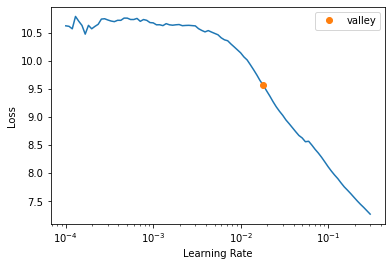

In [56]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [57]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.801899,7.048365,00:02
1,4.661489,7.093891,00:02
2,4.659508,7.021565,00:02
3,4.587820,7.003131,00:02
4,4.538014,7.032785,00:02


In [58]:
df.query('Season==22 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')[['HC', 'AC']]

,HC,AC
3770,3.0,2.0


In [59]:
def predict(self, row):
    "Predict on a Pandas Series"
    dl = self.dls.test_dl(row.to_frame().T)
    dl.dataset.conts = dl.dataset.conts.astype(np.float32)
    inp,preds,_ = self.get_preds(dl=dl, with_input=True, with_decoded=False)
    b = tuplify(inp)
    full_dec = self.dls.decode(b)
    return full_dec,preds[0]

learn_bnb.predict = MethodType(predict, learn_bnb)

In [60]:
_, params = learn_bnb.predict(df.query('Season==21 and HomeTeam=="Chelsea" and AwayTeam=="Man City"')
                                .drop(columns=y_names).iloc[0])

In [61]:
params

tensor([ -2.2450,  -2.2514,   3.4667,   5.5701, -46.4752])

In [62]:
alpha = F.softplus(params[0:2])
mu = F.softplus(params[2:4])
omega = params[4]
# omega = torch.tanh(params[4]) * 50.

total_count = 1. / alpha
logits = torch.log(alpha * mu)

print(alpha, mu, omega)

tensor([0.1007, 0.1001]) tensor([3.4974, 5.5739]) tensor(-46.4752)


In [63]:
bnb_corner = BivariateNegativeBinomialSL(total_count=total_count, omega=omega, logits=logits)

In [64]:
print(bnb_corner.mean, bnb_corner.variance)

tensor([3.4974, 5.5739]) tensor([4.7290, 8.6831])


In [65]:
# Method 1:
corr = omega * torch.sqrt(mu.prod()) * alpha.prod() / ((1.+alpha)**(1./alpha+1.)).prod() / torch.sqrt((1.+alpha*mu).prod())
corr 

tensor(-0.1749)

In [66]:
# Method 2:
# d = 1.-math.exp(-1)
# corr = omega * d**2 * torch.sqrt(mu.prod()*(1.+alpha*mu).prod()) * ((1.+d*alpha*mu)**(-1-1/alpha)).prod()
# corr 

In [67]:
value = torch.cartesian_prod(torch.arange(0., 15.), torch.arange(0., 15.))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272482218/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


In [68]:
corner = bnb_corner.log_prob(value).exp()

In [69]:
line = 10.5
mask = value.sum(-1) < line
prob_lo = corner[mask].sum()
prob_hi = 1 - prob_lo

In [70]:
prob_lo, prob_hi

(tensor(0.6875), tensor(0.3125))

In [71]:
1/prob_lo, 1/prob_hi

(tensor(1.4546), tensor(3.1995))

### Train full model

In [72]:
to = TabularPandas(df, procs=procs, cat_names=cat_names, cont_names=cont_names, 
                   y_names=y_names, y_block=y_block)

In [73]:
bs = 64
dls = to.dataloaders(bs=bs)
dls.show_batch()

,Div,HomeTeam,AwayTeam,HSLast5Avg,HCLast5Avg,ASLast5Avg,ACLast5Avg,HomeSForLast5Avg,AwaySForLast5Avg,HomeSAgainstLast5Avg,AwaySAgainstLast5Avg,HC,AC,weight
0,I1,Cagliari,Napoli,10.2,3.8,9.800000,7.0,6.8,10.400000,13.200000,4.800000,3.0,8.0,0.871732
1,I1,Udinese,Napoli,10.8,4.6,17.600001,6.2,10.8,16.600001,13.600000,7.200000,2.0,5.0,1.005206
2,SP2,Huesca,Ponferradina,12.2,6.4,12.200000,4.6,12.4,11.200000,13.600000,13.400000,5.0,5.0,1.076468
3,I1,Sassuolo,Genoa,8.6,4.4,5.600000,4.0,9.8,5.200000,14.800000,10.000000,8.0,2.0,0.873166
4,D2,Bielefeld,Bochum,14.0,5.2,10.600000,2.6,15.8,14.600000,12.800000,17.600001,6.0,3.0,0.723161
5,F1,Angers,Clermont,11.4,5.4,11.200000,3.4,9.6,10.800000,10.200000,11.800000,3.0,1.0,1.309050
6,F2,Amiens,Pau FC,13.4,5.2,8.400000,2.8,13.6,9.400000,14.600000,14.400000,6.0,5.0,1.343937
7,E1,Bristol City,Preston,11.6,6.6,8.200000,4.4,9.6,9.800000,11.800000,15.600000,5.0,1.0,1.242651
8,E2,Crewe,Portsmouth,8.2,2.4,10.800000,6.4,8.2,14.600000,16.799999,11.800000,7.0,5.0,1.102737
9,E2,Lincoln,Tranmere,9.6,4.6,10.600000,6.0,8.4,11.600000,13.400000,11.400000,6.0,5.0,0.705548


In [74]:
learn_bnb = tabular_learner(dls, layers=[240, 120], n_out=5)

In [75]:
learn_bnb.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(12, 6)
    (1): Embedding(272, 37)
    (2): Embedding(272, 37)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=88, out_features=240, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=240, out_features=120, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=120, out_features=5, bias=True)
    )
  )
)

In [76]:
learn_bnb.loss_func = BivariateNegativeBinomialSLNLLLoss()
learn_bnb.loss_func

BivariateNegativeBinomialSLNLLLoss()

SuggestedLRs(valley=0.012835503555834293)

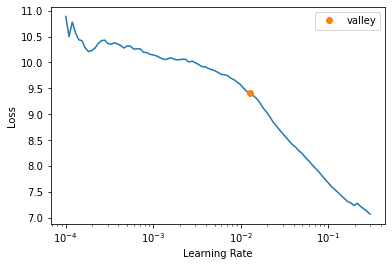

In [77]:
learn_bnb.lr_find(start_lr=1e-04, end_lr=5e-01)

In [78]:
learn_bnb.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,time
0,4.978816,None,00:02
1,4.657434,None,00:02
2,4.657988,None,00:02
3,4.602112,None,00:02
4,4.583969,None,00:02


/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/fastprogress/fastprogress.py:74: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


In [79]:
learn_bnb.export('models/learn_bnbsl.pkl')

In [80]:
to.export('models/to.pkl')

### t-SNE

In [81]:
df['HomeTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Alaves', 'Albacete',
       'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta',
       'Andorra', 'Angers', 'Annecy', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Bari', 'Barnsley', 'Bastia', 'Bayern Munich',
       'Benevento', 'Betis', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Braunschweig', 'Brentford', 'Brescia', 'Brest',
       'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley',
       'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff',
       'Carlisle', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'Doncaster'

In [82]:
df['AwayTeam'].astype('category').cat.categories.values

array(['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Alaves', 'Albacete',
       'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta',
       'Andorra', 'Angers', 'Annecy', 'Arsenal', 'Ascoli', 'Aston Villa',
       'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre',
       'Barcelona', 'Bari', 'Barnsley', 'Bastia', 'Bayern Munich',
       'Benevento', 'Betis', 'Bielefeld', 'Birmingham', 'Blackburn',
       'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux',
       'Bournemouth', 'Braunschweig', 'Brentford', 'Brescia', 'Brest',
       'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley',
       'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff',
       'Carlisle', 'Cartagena', 'Castellon', 'Celta', 'Chambly',
       'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo',
       'Cittadella', 'Clermont', 'Como', 'Cosenza', 'Coventry',
       'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt',
       'Derby', 'Dijon', 'Doncaster'

In [83]:
variable = 'HomeTeam'
ix = cat_names.index(variable)

var_vals = list(df[variable].astype('category').cat.categories.values)
nval = len(var_vals)
print(f'Number of values: {nval}')
print(var_vals)

Number of values: 271
['AFC Wimbledon', 'Accrington', 'Ajaccio', 'Alaves', 'Albacete', 'Alcorcon', 'Alessandria', 'Almeria', 'Amiens', 'Amorebieta', 'Andorra', 'Angers', 'Annecy', 'Arsenal', 'Ascoli', 'Aston Villa', 'Atalanta', 'Ath Bilbao', 'Ath Madrid', 'Augsburg', 'Auxerre', 'Barcelona', 'Bari', 'Barnsley', 'Bastia', 'Bayern Munich', 'Benevento', 'Betis', 'Bielefeld', 'Birmingham', 'Blackburn', 'Blackpool', 'Bochum', 'Bologna', 'Bolton', 'Bordeaux', 'Bournemouth', 'Braunschweig', 'Brentford', 'Brescia', 'Brest', 'Brighton', 'Bristol City', 'Bristol Rvs', 'Burgos', 'Burnley', 'Burton', 'Cadiz', 'Caen', 'Cagliari', 'Cambridge', 'Cardiff', 'Carlisle', 'Cartagena', 'Castellon', 'Celta', 'Chambly', 'Charlton', 'Chateauroux', 'Chelsea', 'Cheltenham', 'Chievo', 'Cittadella', 'Clermont', 'Como', 'Cosenza', 'Coventry', 'Cremonese', 'Crewe', 'Crotone', 'Crystal Palace', 'Darmstadt', 'Derby', 'Dijon', 'Doncaster', 'Dortmund', 'Dresden', 'Dunkerque', 'Eibar', 'Ein Frankfurt', 'Elche', 'Empoli',

In [84]:
# import altair as alt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

emb_mx = to_np(next(learn_bnb.model.embeds[ix].parameters()))
#X_emb = TSNE(n_components=2, perplexity=3).fit_transform(emb_mx)
#X_emb = PCA(n_components=2).fit_transform(emb_mx)
annotation = np.append('Other', np.array(var_vals))

/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/twtang/miniconda3/envs/fastai2/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' 

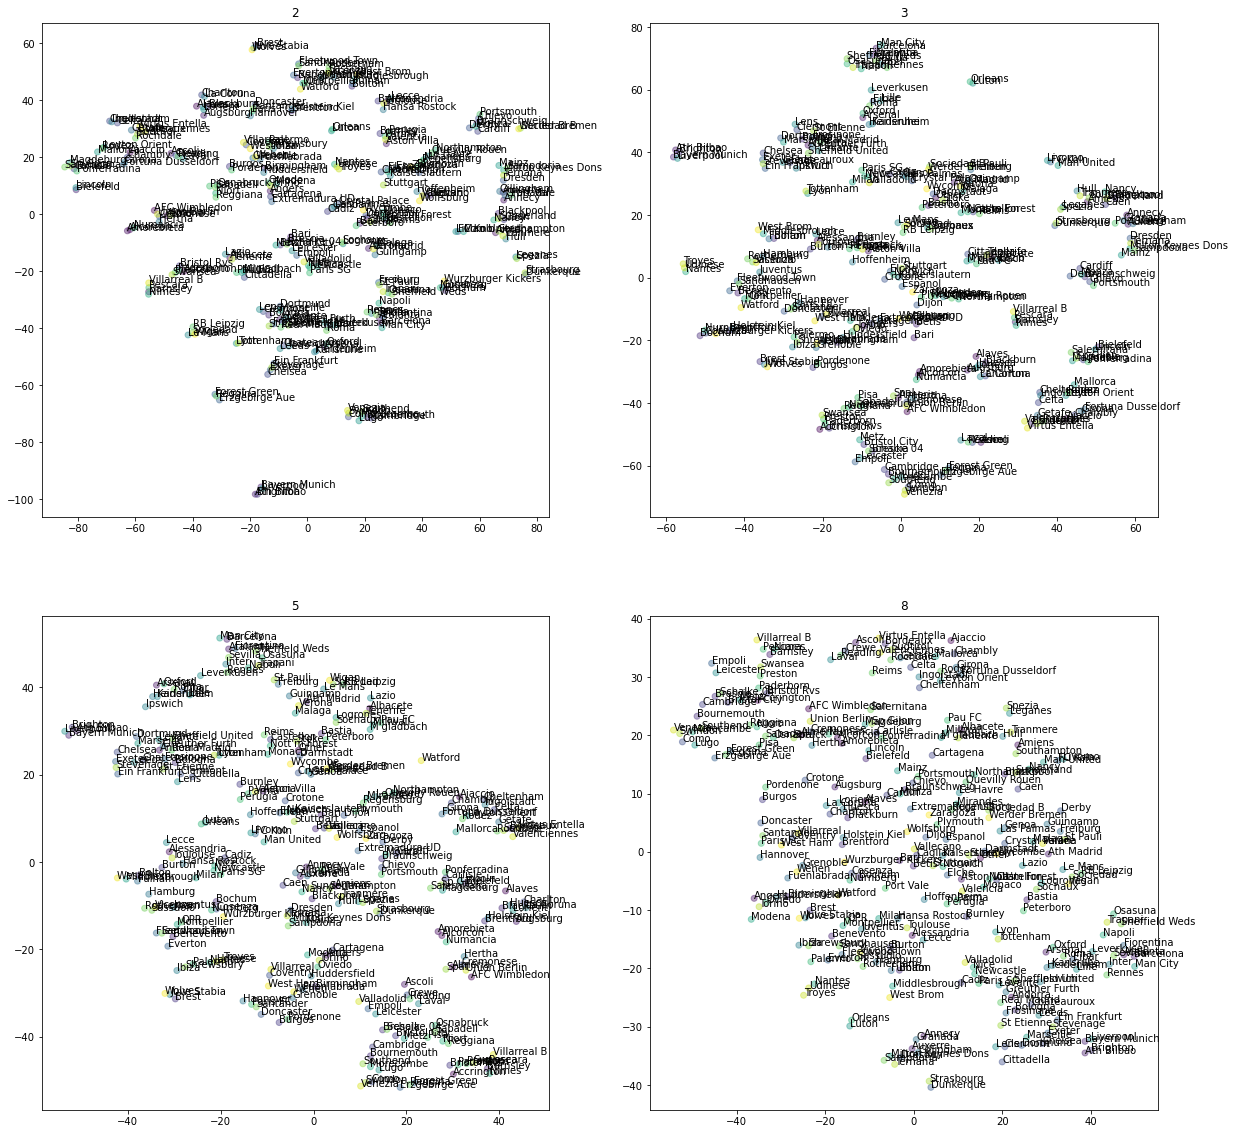

In [85]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fig.set_figheight(20)
fig.set_figwidth(20)

perplexity = [2, 3, 5, 8]
for ax,perp in zip(axes.flatten(), perplexity):
    X_emb = TSNE(n_components=2, perplexity=perp).fit_transform(emb_mx)
    ax.scatter(X_emb[:,0], X_emb[:,1], c=range(len(annotation)), alpha=0.4)
    for xy,target in zip(X_emb, annotation):
        if isinstance(target, np.str_) or isinstance(target, str):
            text = target
        else:
            text = "%d" % target
        ax.annotate(text=text, xy=(xy[0], xy[1]))
        ax.set_title(perp)

# END